In [1]:
import DW_oscillator as DW
import numpy as np
from IPython.display import clear_output
from torchdiffeq import odeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
def get_batch(true_y,time, batch_size):
    num_samples = len(true_y)
    indices = np.random.choice(np.arange(num_samples - batch_size, dtype=np.int64), size=batch_size, replace=False)
    indices.sort()
    batch_y0 = true_y[indices]  # (batch_size, D)
    batch_t = time[:batch_size]  # (batch_size)
    batch_y = torch.stack([true_y[indices + i] for i in range(batch_size)], dim=0)  # (batch_size, M, D)
    indices = torch.tensor(indices)
    return batch_y0,batch_t,batch_y,indices

In [320]:
t, y, h_t, fields, periods = DW.run_field_sequence(field_low = 100, field_high = 100.0, N_fields = 1, T = 60,y0 = [0.0,0.0])

[100.]
[60.]


In [5]:
#h_t_ = torch.div(torch.tensor(h_t, dtype=torch.float64),1000.).to(device)  # Converting to column vector
y_0_ = torch.tensor(y[0], dtype=torch.float64)  # Converting to column vector
y_1_ = torch.tensor(y[1], dtype=torch.float64)  # Converting to column vector

# Stack the tensors horizontally
data = torch.stack((torch.div(y_0_, 1000.),y_1_)).to(device)  # Converting to column vector

Text(0.5, 1.0, 'Phase Space of Single field DW')

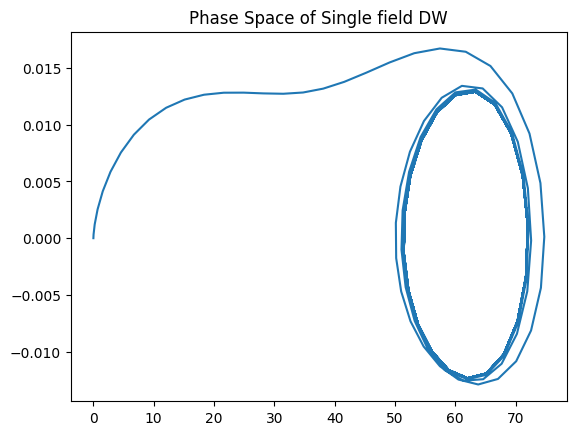

In [321]:
plt.plot(y[0],y[1])
plt.title('Phase Space of Single field DW')

In [6]:
train = data[:,:].transpose(0,1).to(device)

In [7]:
time_train = torch.tensor(t).to(device)

In [8]:
class sequence:
    """
    Callable class to produce a time-dependent field sequence using PyTorch tensors.
    """
    def __init__(self, fields, periods):
        self.fields = torch.tensor(fields, dtype=torch.float64).to(device)
        self.periods = torch.tensor(periods, dtype=torch.float64).to(device)
        self.periods_sum = torch.cumsum(self.periods, dim=0)

    def __call__(self, t):
        if t < 0.0:
            val = torch.tensor(0.0, dtype=torch.float64)
        elif t >= self.periods_sum[-1]:
            val = torch.tensor(0.0, dtype=torch.float64)
        else:
            t_diff = self.periods_sum - t
            n = 0
            for i in range(len(t_diff)):
                if t_diff[i] >= 0.0:
                    n = i 
                    break
            #n = torch.argmax(t_diff >= 0.0)  # Find the first index where t_diff >= 0.0
            val = self.fields[n]
        return val

In [9]:
h_time = sequence(fields,periods)

In [10]:
train.shape

torch.Size([600, 2])

In [11]:
class DWODE(nn.Module):
    """
    neural network for learning the chaotic lorenz system
    """
    def __init__(self, h_time, frequency ):
        super(DWODE, self).__init__()
        self.lin = nn.Linear(3, 128)
        self.lin2 = nn.Linear(128, 256)
        self.lin3 = nn.Linear(256,512)
        self.lin4 = nn.Linear(512,1024)
        self.lin5 = nn.Linear(1024,2)
        self.tanh = nn.Tanh()
        self.lrelu = nn.LeakyReLU()
        self.h_time = h_time #  function to return the field magnitude at time t
        self.omega = 2*torch.pi * frequency # store the angular frequency for calculating field
        self.tanh = nn.Tanh()
        self.lrelu = nn.LeakyReLU()
        self.nfe = 0

    def forward(self,t,x):
        self.nfe += 1
        if flag == False:
            h_accumulator = torch.zeros_like(intervals, dtype=torch.float64)
            for i,j in enumerate(intervals):
            
                h = self.h_time(j) * torch.sin(self.omega*j )
                h_accumulator[i] = h
            h = torch.div(h_accumulator,1000.).unsqueeze(1)
        else : 
            h = self.h_time(t) * torch.sin(self.omega*t)
            h = torch.div(h,1000.).unsqueeze(0).unsqueeze(0)
        x_aug = torch.cat([x, h], 1)
        x = self.lrelu(self.lin(x_aug))
        x = self.lrelu(self.lin2(x))
        x = self.lrelu(self.lin3(x))
        x = self.lrelu(self.lin4(x))
        x = self.lin5(x)
        return x
     

In [13]:
model = DWODE(h_time,frequency=0.5).double().to(device)

In [14]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [12]:
from torchdiffeq import odeint_adjoint as adjoint

In [13]:
flag = False

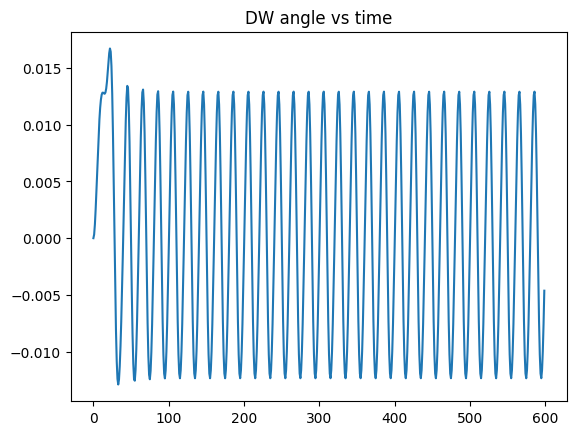

In [323]:
plt.plot(y[1])
plt.title('DW angle vs time')
plt.show()

Iter 0900 | Total Loss 0.000022


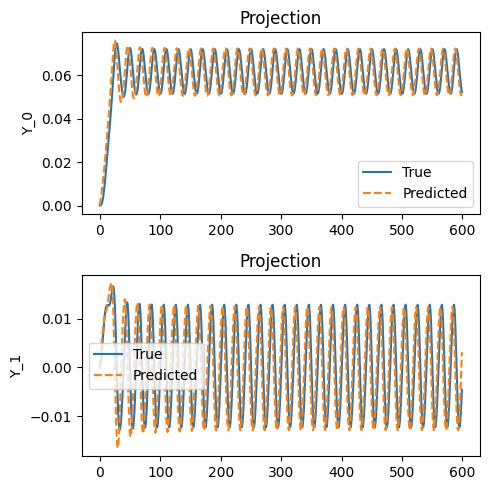

In [18]:
losses = []
whole_losses = []
best_loss = 100.0
batch_size = 16
for i in range(1000):

    optimizer.zero_grad()
    
    init,batch_t,truth,indices = get_batch(train,time_train,batch_size)
    intervals = time_train[indices]
    #print(init,batch_t,truth)
    pred_y = adjoint(model,init,batch_t,method='dopri5')
    loss = F.huber_loss(pred_y, truth)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(model.state_dict(), 'saved_models/forward_field_onlylrelu_2.pth')
    if i % 100 == 0:
        
        with torch.no_grad():
            flag = True
            intervals = time_train
            pred_y = adjoint(model, train[0].view(1,-1), time_train,method='dopri5')
            pred_y = pred_y.squeeze(1)
            loss = F.huber_loss(pred_y, train)
            whole_losses.append(loss.item())
            flag = False
            print('Iter {:04d} | Total Loss {:.6f}'.format(i, loss.item()))
            x_pred = pred_y[:,0].cpu()
            y_pred = pred_y[:,1].cpu()
            

            # Extract the x, y, z coordinates from X_train_plt
            x_train = train[:,0].cpu()
            y_train = train[:,1].cpu()
            

            fig, ax = plt.subplots(2, 1, figsize=(5, 5))
            ax[0].plot(x_train, label='True')
            ax[0].plot(x_pred, label='Predicted', linestyle='--')
            ax[0].set_ylabel('Y_0')
            ax[0].set_title('Projection')
            ax[0].legend()

            ax[1].plot(y_train, label='True')
            ax[1].plot(y_pred, label='Predicted',linestyle='--')
            ax[1].set_ylabel('Y_1')
            ax[1].set_title('Projection')
            ax[1].legend()


            plt.tight_layout()
            plt.show()
            clear_output(wait=True)

In [19]:
print(best_loss)

7.989913837478219e-08


In [15]:
test_model = DWODE(h_time,frequency=0.5).double().to(device)

In [16]:
test_model.load_state_dict(torch.load('saved_models/forward_field_onlylrelu_2.pth'))

<All keys matched successfully>

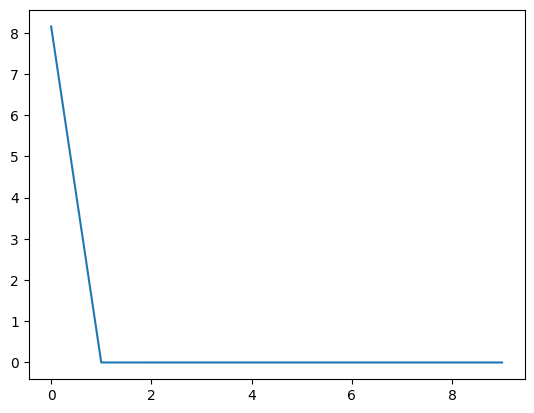

In [23]:
plt.plot(whole_losses)
plt.show()

In [24]:
with torch.no_grad():
    flag = True
    pred = adjoint(test_model, train[0].view(1,-1), time_train,method='dopri5')
    flag = False

In [25]:
pred = pred.cpu().detach().numpy()

In [26]:
pred = pred.squeeze(1)

In [27]:
pred.shape,train.shape

((600, 2), torch.Size([600, 2]))

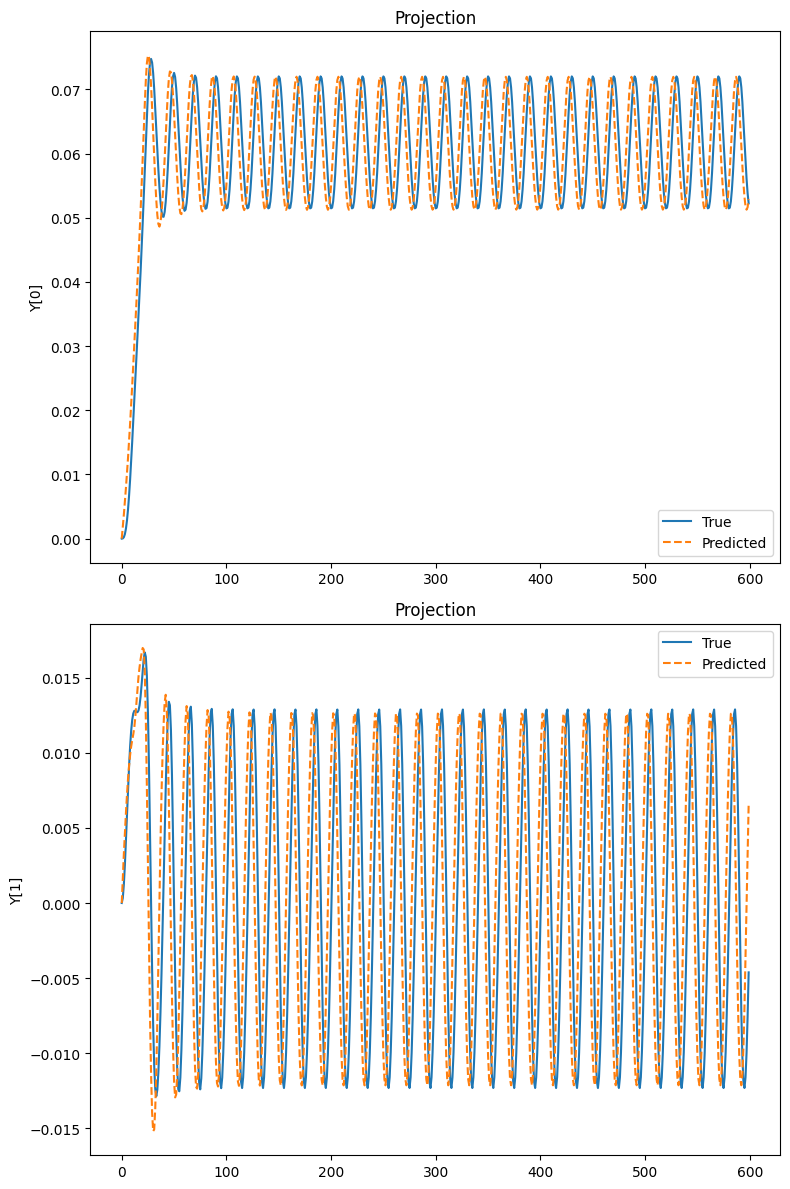

In [28]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = pred[:,0]
y_pred = pred[:,1]


# Extract the x, y, z coordinates from X_train_plt
x_train = train[:,0].cpu()
y_train = train[:,1].cpu()

fig, ax = plt.subplots(2, 1, figsize=(8, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred, label='Predicted',linestyle='--')
ax[0].set_ylabel('Y[0]')
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred, label='Predicted',linestyle='--')
ax[1].set_ylabel('Y[1]')
ax[1].set_title('Projection')

ax[1].legend()
plt.savefig('forward_field_onlylrelu_2_2.png')
plt.tight_layout()
plt.show()

In [43]:
t_, y_, ht, fields_, periods_ = DW.run_field_sequence(field_low = 100, field_high = 100.0, N_fields = 1, T = 100,y0 = [20.0,0.0])

[100.]
[100.]


In [174]:

t_, y_, ht, fields_, periods_ = DW.run_field_sequence(field_low = 100, field_high = 100.0, N_fields = 1, T = 100,y0 = [20.,0.])
h_t_ = torch.div(torch.tensor(ht, dtype=torch.float64),1000.).to(device)  # Converting to column vector
y_0_ = torch.tensor(y_[0], dtype=torch.float64)  # Converting to column vector
y_1_ = torch.tensor(y_[1], dtype=torch.float64)  # Converting to column vector

# Stack the tensors horizontally
data_ = torch.stack((torch.div(y_0_, 1000.),y_1_)).to(device)  # Converting to column vector

    

[100.]
[100.]


In [175]:
test_time_0 = torch.tensor(t_).to(device)

In [176]:
test_0 = data_[:,:].transpose(0,1).to(device)

In [177]:
test_0.shape

torch.Size([1000, 2])

In [178]:
h_time = sequence(fields_,periods_)

In [264]:
test_model = DWODE(h_time,frequency=0.5).double().to(device)

In [265]:
test_model.load_state_dict(torch.load('saved_models/forward_field_onlylrelu_2.pth'))

<All keys matched successfully>

In [181]:
with torch.no_grad():
    flag = True
    pred = adjoint(test_model, test_0[0].view(1,-1), test_time_0,method='dopri5')
    loss = F.mse_loss(pred.squeeze(1), test_0)
    flag = False

In [222]:
def plot_vector_field(pred,label):
    for idx in range(len(pred)):
        positions = pred[idx][:,:2]  # Extracting the 3 components as positions

        # Create a new tensor with requires_grad=True
        positions = positions.clone().detach().requires_grad_(True)

        # Calculate the vector field by taking the derivatives of positions
        vector_field = torch.autograd.grad(positions, positions, torch.ones_like(positions), create_graph=True)[0]

        # Extract the x, y, and z components of the vector field
        U = vector_field[:, 0]
        V = vector_field[:, 1]
        

        # Move tensors to CPU before converting to NumPy arrays
        positions = positions.cpu().detach().numpy()
        U = U.cpu().detach().numpy()
        V = V.cpu().detach().numpy()
        

        # Create a subset of positions for the arrows
        arrow_step = 1  # Adjust this to change the density of arrows
        arrow_positions = positions[::arrow_step]

        # Calculate arrow directions by normalizing the vector field components
        magnitude = np.sqrt(U**2 + V**2)
        arrow_U = U / magnitude
        arrow_V = V / magnitude

        # Plot the vector field with arrows
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.quiver(arrow_positions[:, 0], arrow_positions[:, 1], arrow_U[::arrow_step], arrow_V[::arrow_step], width=0.004, alpha=0.6)
        # ax.set_xticks([])  # Remove x-axis ticks
        # ax.set_yticks([])  # Remove y-axis ticks
        # ax.set_xlabel('')   # Remove x-axis label
        # ax.set_ylabel('')   # Remove y-axis label
        plt.title(f'Domain Wall single field  Vector Field of {label}_{idx}  Predictions')
        plt.savefig(f'PNG/pdomain_NODE_Vector_Field_{label}_{idx}.png', format='png', dpi=400, bbox_inches ='tight', pad_inches = 0.1)
        plt.tight_layout()
        plt.show()

In [223]:
to_vector_0 = pred.squeeze(1).unsqueeze(0)

In [183]:
pred.shape

torch.Size([1000, 1, 2])

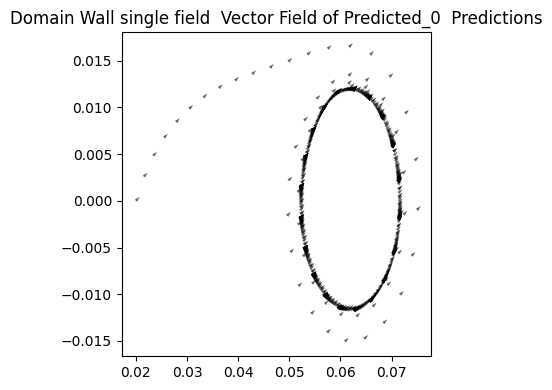

In [224]:
plot_vector_field(to_vector_0,'Predicted')

Text(0.5, 1.0, 'Test Set 0 True')

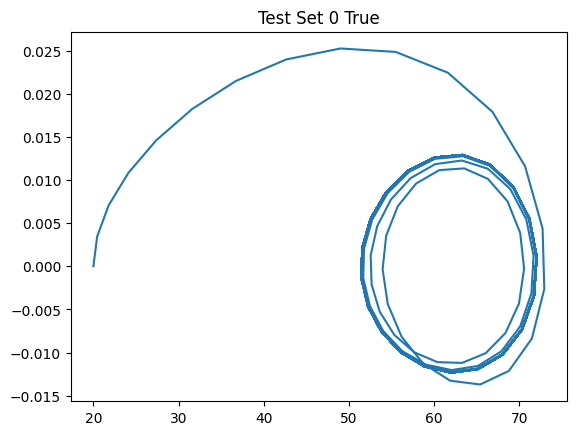

In [185]:
plt.plot(y_[0],y_[1])
plt.title('Test Set 0 True')

In [186]:
loss

tensor(0.0002, device='cuda:0', dtype=torch.float64)

In [187]:
pred = pred.cpu().detach().numpy()

In [188]:
pred = pred.squeeze(1)

In [189]:
pred.shape,test_0.shape

((1000, 2), torch.Size([1000, 2]))

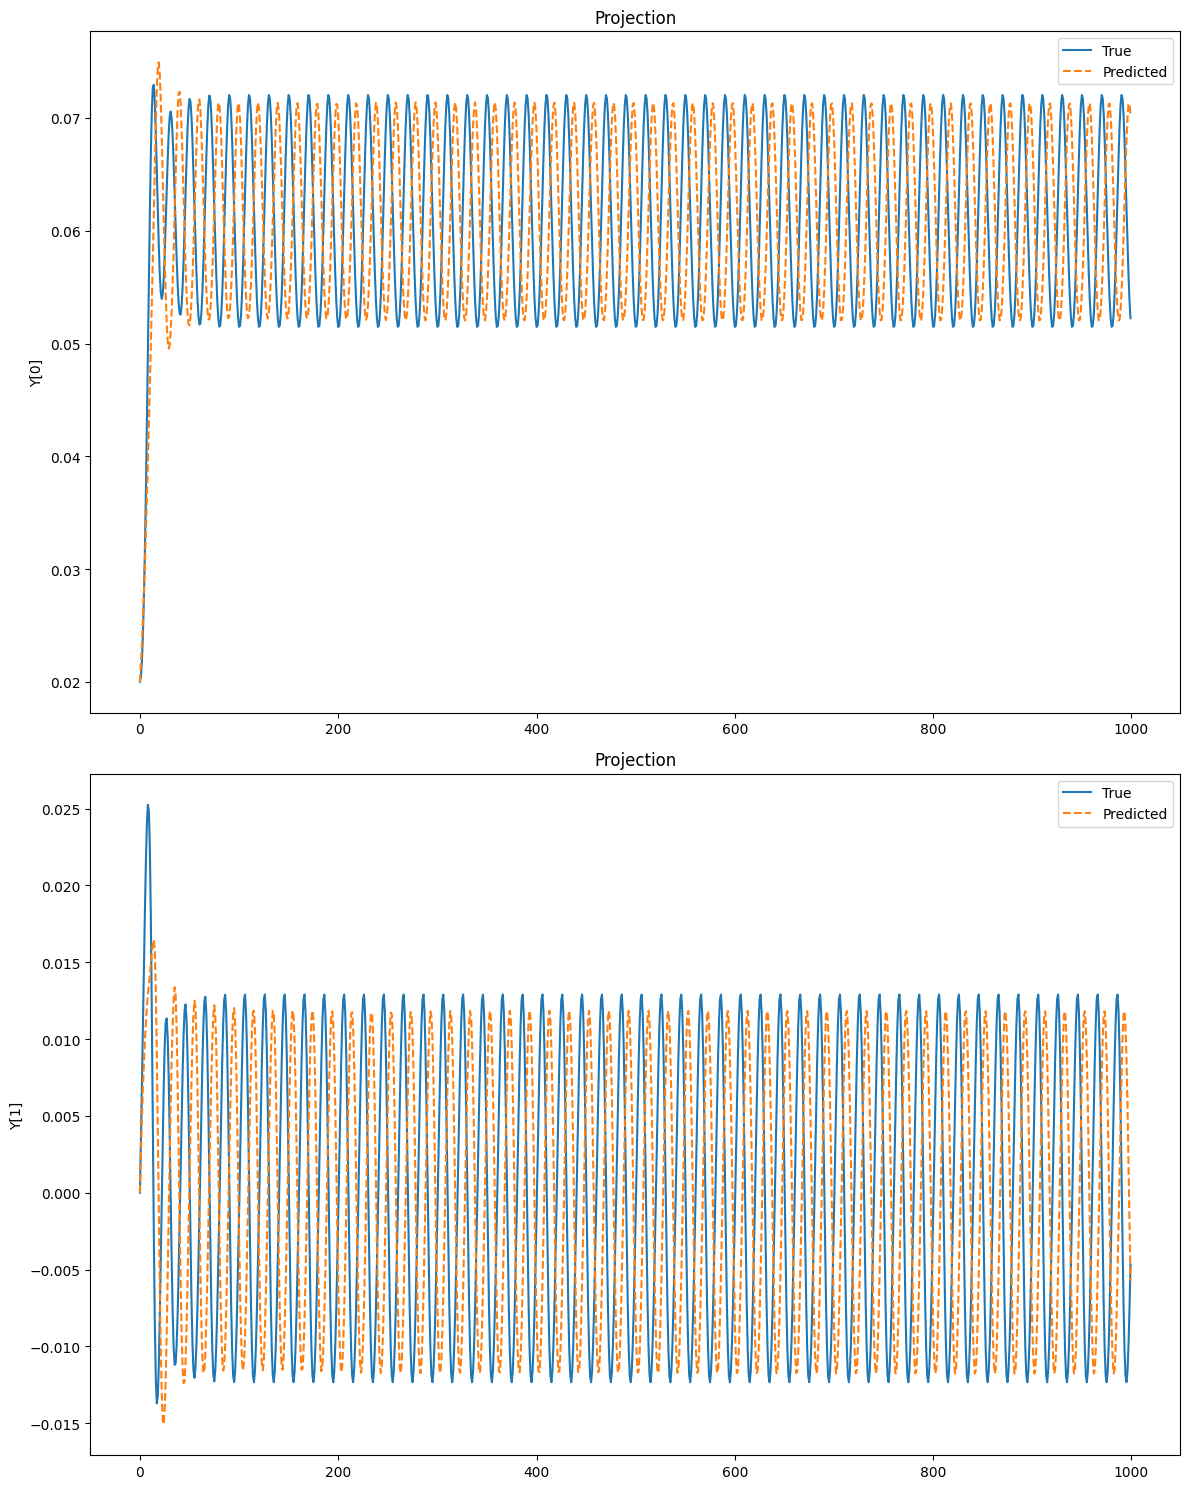

In [190]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = pred[:,0]
y_pred = pred[:,1]


# Extract the x, y, z coordinates from X_train_plt
x_train = test_0[:,0].cpu()
y_train = test_0[:,1].cpu()

fig, ax = plt.subplots(2, 1, figsize=(12, 15))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred, label='Predicted',linestyle='--')
ax[0].set_ylabel('Y[0]')
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred, label='Predicted',linestyle='--')
ax[1].set_ylabel('Y[1]')
ax[1].set_title('Projection')

ax[1].legend()
plt.savefig('forward_field_onlylrelu_20pos_noaug_2.png')
plt.tight_layout()
plt.show()

In [211]:

t_1,y_1, ht_1, fields_1, periods_1 = DW.run_field_sequence(field_low = 100, field_high = 100.0, N_fields = 1, T = 100,y0 = [60.,0.])
h_t_ = torch.div(torch.tensor(ht_1, dtype=torch.float64),1000.).to(device)  # Converting to column vector
y_0_ = torch.tensor(y_1[0], dtype=torch.float64)  # Converting to column vector
y_1_ = torch.tensor(y_1[1], dtype=torch.float64)  # Converting to column vector

# Stack the tensors horizontally
data_ = torch.stack((torch.div(y_0_, 1000.),y_1_)).to(device)  # Converting to column vector

    

[100.]
[100.]


In [212]:
test_time = torch.tensor(t_1).to(device)

In [213]:
test_1 = data_[:,:].transpose(0,1).to(device)

In [214]:
h_time = sequence(fields_1,periods_1)

In [215]:
with torch.no_grad():
    flag = True
    pred_1 = adjoint(test_model, test_1[0].view(1,-1), test_time,method='dopri5')
    loss_1 = F.mse_loss(pred.squeeze(1), test_1)
    flag = False

In [216]:
print(f'loss is {loss_1:.8f}')

loss is 0.00021992


In [217]:
to_vector_1 = pred_1.squeeze(1).unsqueeze(0)

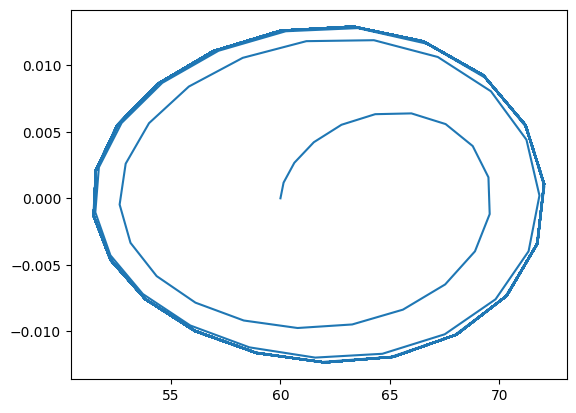

In [218]:
plt.plot(y_1[0],y_1[1])

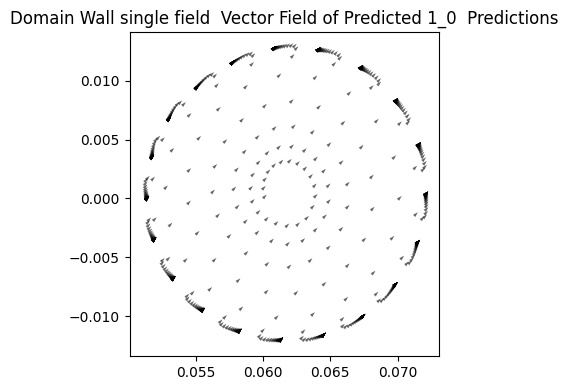

In [225]:
plot_vector_field(to_vector_1,'Predicted 1')

In [220]:
pred_1 = pred_1.cpu().detach().numpy().squeeze(1)

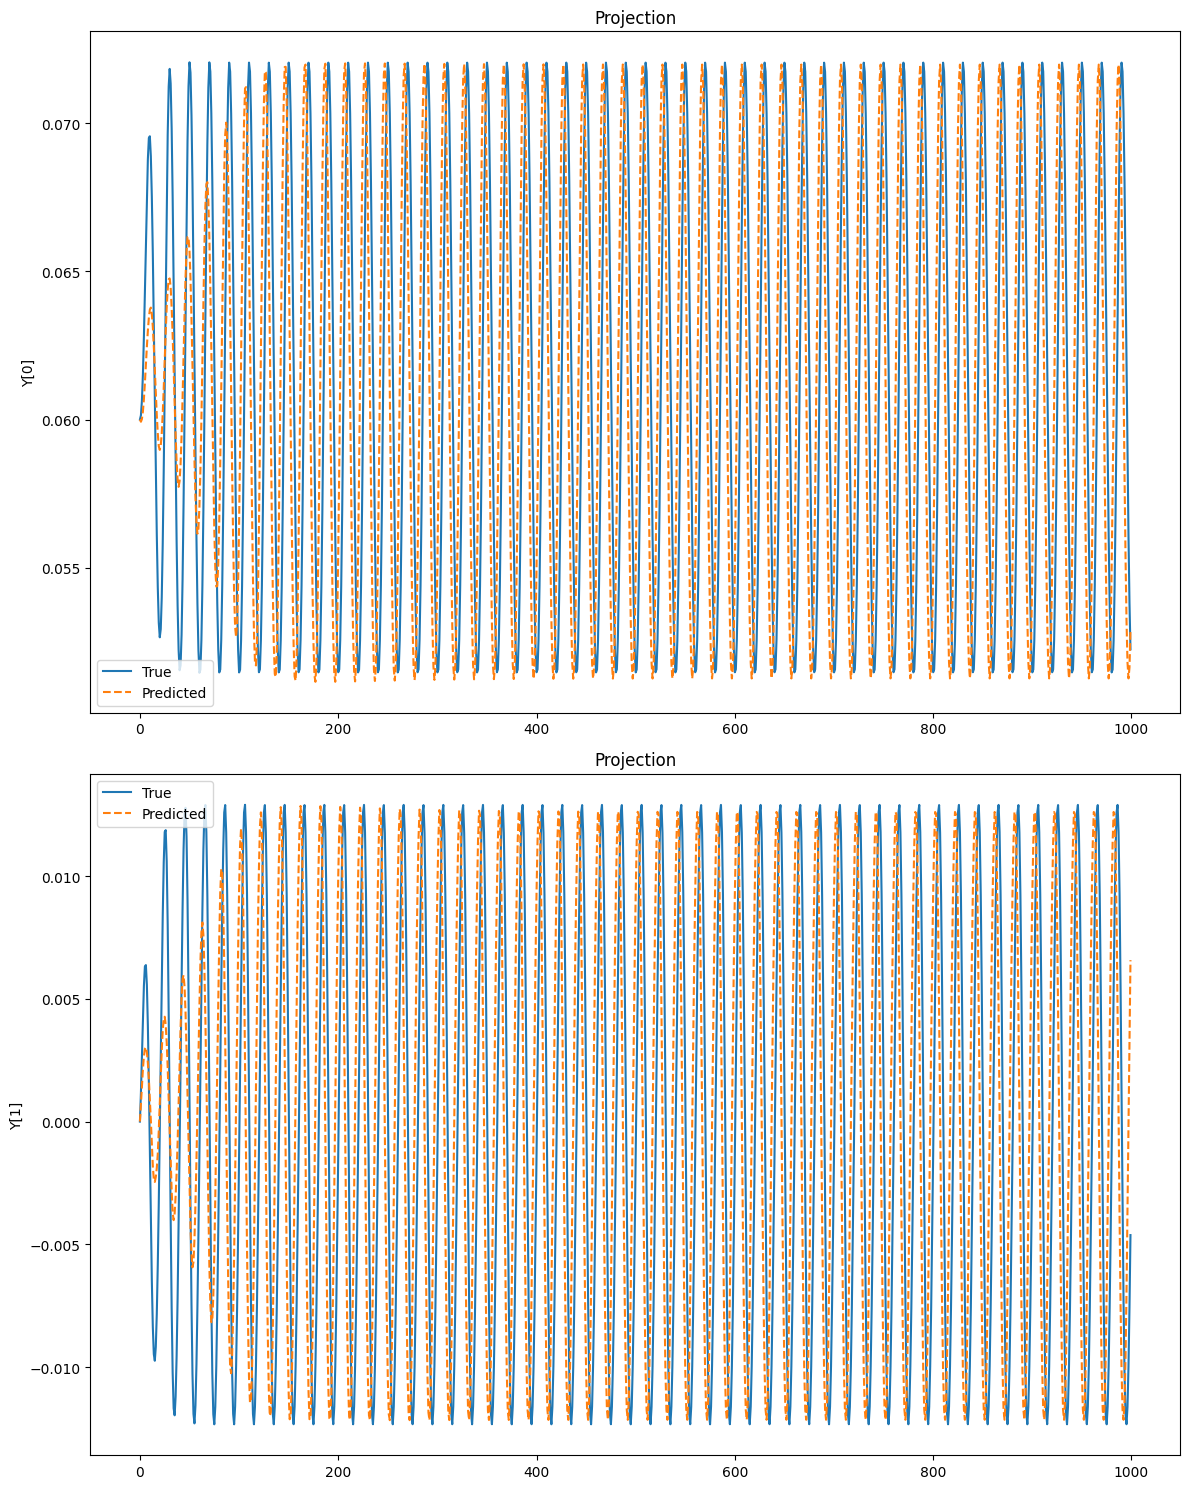

In [221]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = pred_1[:,0]
y_pred = pred_1[:,1]


# Extract the x, y, z coordinates from X_train_plt
x_train = test_1[:,0].cpu()
y_train = test_1[:,1].cpu()

fig, ax = plt.subplots(2, 1, figsize=(12, 15))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred, label='Predicted',linestyle='--')
ax[0].set_ylabel('Y[0]')
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred, label='Predicted',linestyle='--')
ax[1].set_ylabel('Y[1]')
ax[1].set_title('Projection')

ax[1].legend()
plt.savefig('forward_field_onlylrelu_60pos_noaug_2.png')
plt.tight_layout()
plt.show()

In [305]:

t_2,y_2, ht_2, fields_2, periods_2 = DW.run_field_sequence(field_low = 150, field_high = 500.0, N_fields = 1, T = 100,y0 = [0.,0.])
h_t_ = torch.div(torch.tensor(ht_2, dtype=torch.float64),1000.).to(device)  # Converting to column vector
y_0_ = torch.tensor(y_2[0], dtype=torch.float64)  # Converting to column vector
y_1_ = torch.tensor(y_2[1], dtype=torch.float64)  # Converting to column vector

# Stack the tensors horizontally
data_ = torch.stack((torch.div(y_0_, 1000.),y_1_)).to(device)  # Converting to column vector

    

[177.58313886]
[100.]


In [306]:
test_2 = data_[:,:].transpose(0,1).to(device)

In [307]:
h_time = sequence(fields_2,periods_2)

In [308]:
with torch.no_grad():
    flag = True
    pred_2 = adjoint(test_model, test_2[0].view(1,-1), test_time,method='dopri5')
    loss_2 = F.mse_loss(pred.squeeze(1), test_2)
    flag = False

In [309]:
print(f'loss is {loss_2:.8f}')

loss is 0.00038386


In [310]:
to_vector_2 = pred_2.squeeze(1).unsqueeze(0)

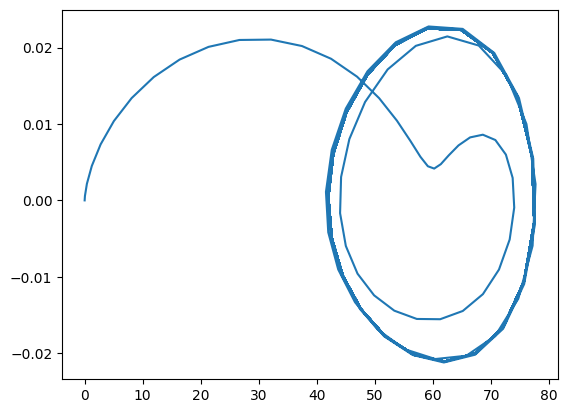

In [311]:
plt.plot(y_2[0],y_2[1])

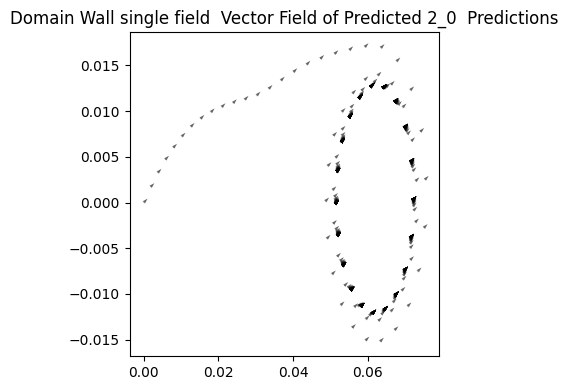

In [312]:
plot_vector_field(to_vector_2,'Predicted 2')

In [313]:
pred_2 = pred_2.cpu().detach().numpy().squeeze(1)

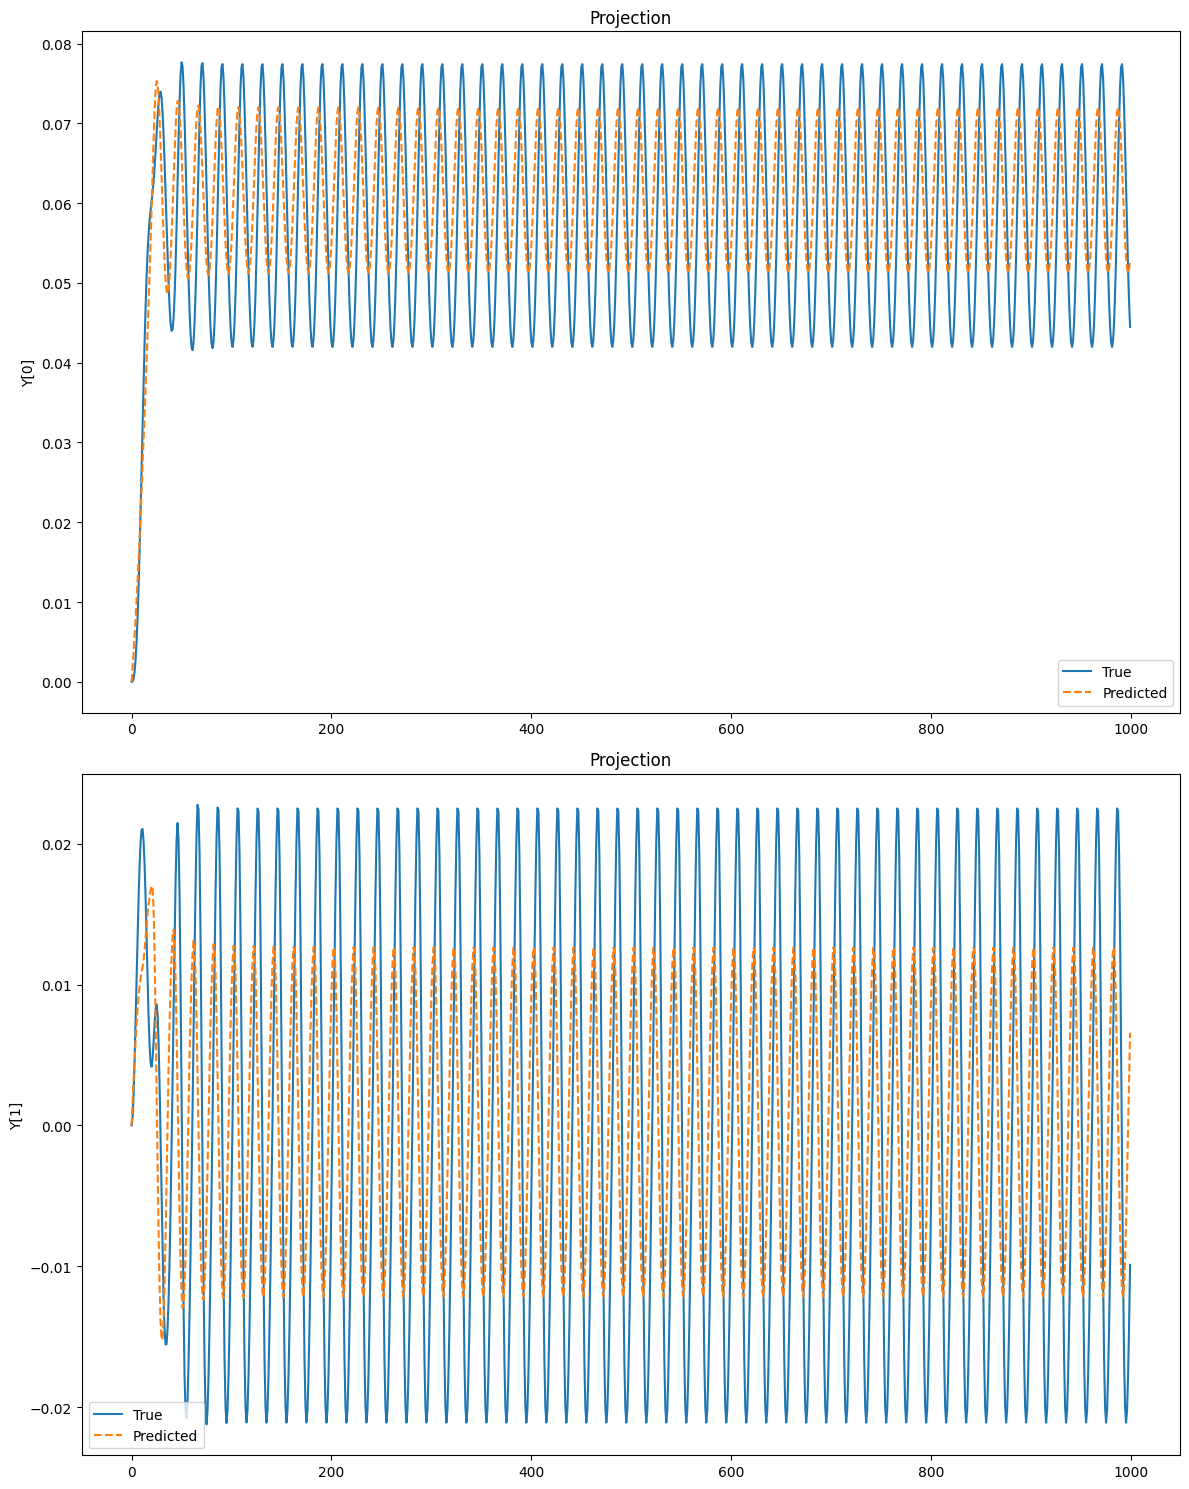

In [314]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = pred_2[:,0]
y_pred = pred_2[:,1]


# Extract the x, y, z coordinates from X_train_plt
x_train = test_2[:,0].cpu()
y_train = test_2[:,1].cpu()

fig, ax = plt.subplots(2, 1, figsize=(12, 15))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred, label='Predicted',linestyle='--')
ax[0].set_ylabel('Y[0]')
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred, label='Predicted',linestyle='--')
ax[1].set_ylabel('Y[1]')
ax[1].set_title('Projection')

ax[1].legend()
plt.savefig('forward_field_onlylrelu_60-30pos_noaug_2.png')
plt.tight_layout()
plt.show()